# Darts overview

In this notebook will show the overview of [Darts](https://github.com/unit8co/darts).

Darts is a library for easy manipulation and forecasting of time series.
It contains a variety of models, from classics such as ARIMA to neural networks.
The models can all be used in the same way, using `fit()` and `predict()` functions, similar to scikit-learn.
The library also makes it easy to backtest models and combine the predictions of several models and external regressors.

We will show all the available functions in this library, with real-world data.

### Easy install

In [1]:
!pip install u8darts

### Some imports

In [2]:
#hide
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional, Callable
from darts import models, backtesting, metrics
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
from efecty.custom_code import create_fortnights, sumape
%matplotlib inline

In [3]:
pd.plotting.register_matplotlib_converters()

## TimeSeries Class
**Darts** library is based on TimeSeries Class. 
You can create from Pandas DataFrame or Series or a Pandas DatetimeIndex and a NumPy array for the values.
Use as index a Datetime class so you can forecast one entity at a time.

This example will load a Pandas df and select one entity from it and then create a TimeSeries from it.

In [4]:
df = pd.read_csv("efecty/efecty_drawdowns.csv", dtype={"y":float, "entity_id":int, "ds":str}, index_col=0)
df["ds"] = pd.to_datetime(df["ds"], format='%Y-%m-%d')
df.head()

,ds,y,entity_id
0,2019-02-05,3383730.0,995152
1,2019-02-05,988994.0,992133
2,2019-02-05,597150.0,995388
3,2019-02-05,50000.0,902343
4,2019-02-05,1426410.0,993733


In [5]:
df_992133 = df[df.entity_id == 992133]
df_992133.head()

,ds,y,entity_id
1,2019-02-05,988994.0,992133
278,2019-02-06,1238432.0,992133
526,2019-02-07,600000.0,992133
691,2019-02-08,1348550.0,992133
804,2019-02-09,1567525.0,992133


In [6]:
series = TimeSeries.from_dataframe(df_992133, "ds", "y" )

### Fill missing values
TimeSeries add a missing date with `None` as values, and you have to fill nan values with `auto_fillna` function.

`auto_fillna` use [pandas interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) for fill the values.


In [7]:
series = missing_values.auto_fillna(series, method="slinear")

In [8]:
print( f"Length of original dataframe {len(df_992133)}, length of new time series {len(series)} " )

Length of original dataframe 374, length of new time series 390 


### Divide train and validation dataset and plot
Darts functions to split the time series:
* `split_[after|before]` : split for a gived timestamp, return 2 TimeSeries
* `slice_n_points_[after|before]` : split for a gived timestamp and have at most `n` values, return 1 TimeSeries
* `slice` : for a gived start and end timestamp return a timeseries between that period 

For ploting use matplotlib!

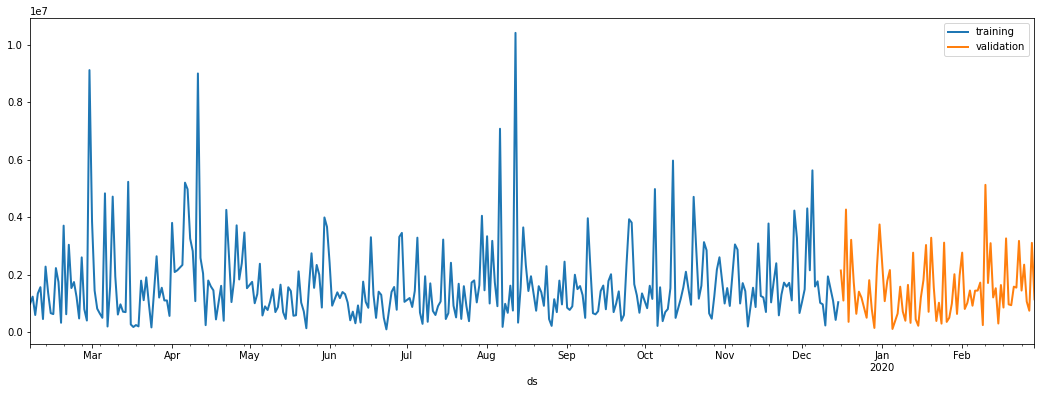

In [9]:
date_division = '20191215'
train, val = series.split_after(pd.Timestamp(date_division))
train.plot(lw=2, label='training', figsize=(18,6))
val.plot(lw=2, label='validation', figsize=(18,6))
plt.legend();

### Add features for multivariate TimeSeries
You can add features for holidays, DateTime attribute, or a custom feature, this last is manually don't have a function for this.
* `add_datetime_attribute`: the attributes are pandas [DatetimeIndex attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html), a second boolean parameter to make the feature one-hot encoding.
* `add_holidays`: add holiday for a specific country
* custom feature

Note that this will create a multivariate TimeSeries and not all the models accept this.

In [10]:
series.add_holidays('ARG')

                    0  1
ds                      
2019-02-05   988994.0  0
2019-02-06  1238432.0  0
2019-02-07   600000.0  0
2019-02-08  1348550.0  0
2019-02-09  1567525.0  0
...               ... ..
2020-02-25  2350000.0  1
2020-02-26  1068926.0  0
2020-02-27   748462.0  0
2020-02-28  3107942.0  0
2020-02-29  1145196.0  0

[390 rows x 2 columns]
Freq: D

In [11]:
series.add_datetime_attribute('weekday', True)

                    0  1  2  3  4  5  6  7
ds                                        
2019-02-05   988994.0  1  0  0  0  0  0  0
2019-02-06  1238432.0  0  1  0  0  0  0  0
2019-02-07   600000.0  0  0  1  0  0  0  0
2019-02-08  1348550.0  0  0  0  1  0  0  0
2019-02-09  1567525.0  0  0  0  0  1  0  0
...               ... .. .. .. .. .. .. ..
2020-02-25  2350000.0  1  0  0  0  0  0  0
2020-02-26  1068926.0  0  1  0  0  0  0  0
2020-02-27   748462.0  0  0  1  0  0  0  0
2020-02-28  3107942.0  0  0  0  1  0  0  0
2020-02-29  1145196.0  0  0  0  0  1  0  0

[390 rows x 8 columns]
Freq: D

To create a custom feature you have to create a new TimeSeries in the same period of your data and then `stack`.

In [12]:
df_quincenas = create_fortnights(series.pd_dataframe().index[0].date(), series.pd_dataframe().index[-1].date())
df_quincenas.set_index("ds", inplace=True)
df_quincenas.replace(to_replace="quincena", value=1, inplace=True)

df_quincena_full = pd.DataFrame({
    "ds":pd.date_range(start=series.pd_dataframe().index[0].date(), end=series.pd_dataframe().index[-1].date()),
    "holiday":0
})
df_quincena_full.set_index("ds", inplace=True)
df_quincena_full.update(df_quincenas)
quincena_ts = TimeSeries.from_dataframe(df_quincena_full, time_col=None, value_cols="holiday" )
series.stack(quincena_ts)

                    0    1
ds                        
2019-02-05   988994.0  0.0
2019-02-06  1238432.0  0.0
2019-02-07   600000.0  0.0
2019-02-08  1348550.0  0.0
2019-02-09  1567525.0  0.0
...               ...  ...
2020-02-25  2350000.0  0.0
2020-02-26  1068926.0  0.0
2020-02-27   748462.0  0.0
2020-02-28  3107942.0  1.0
2020-02-29  1145196.0  0.0

[390 rows x 2 columns]
Freq: D

## Models
Darts have many models, all of the sklearn compatible(fit, predict API). 
The models accept the parameters they expect to create the models.
Models:
* Naive models (Drift, seasonal)
* Exponential smoothing,
* ARIMA & auto-ARIMA,
* Facebook Prophet,
* [Theta method](https://robjhyndman.com/papers/Theta.pdf),
* FFT (Fast Fourier Transform),
* Recurrent neural networks (vanilla RNNs, GRU, and LSTM variants),
* Temporal convolutional network [(TCN)](https://arxiv.org/pdf/1608.08242.pdf).

You can also create an ensemble of models and apply a Standard regression over them. 

In [13]:
model = models.Prophet()
model.fit(train)
prediction = model.predict(len(val))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 0, 'Year')

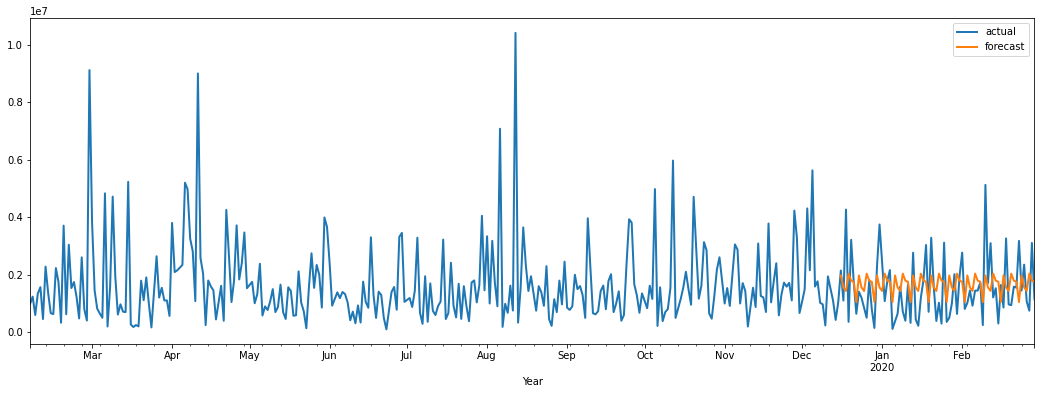

In [14]:
series.plot(label="actual", lw=2, figsize=(18,6))
prediction.plot(label="forecast", lw=2, figsize=(18,6))
plt.legend()
plt.xlabel("Year")

### Add holidays

In [15]:
fortnights = create_fortnights(series.pd_dataframe().index[0].date(), series.pd_dataframe().index[-1].date())

In [16]:
model = models.Prophet(holidays=quincenas, interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
train.add_holidays(country_code="COL")
model.fit(train)
prediction_prophet = model.predict(len(val))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Text(0.5, 0, 'Year')

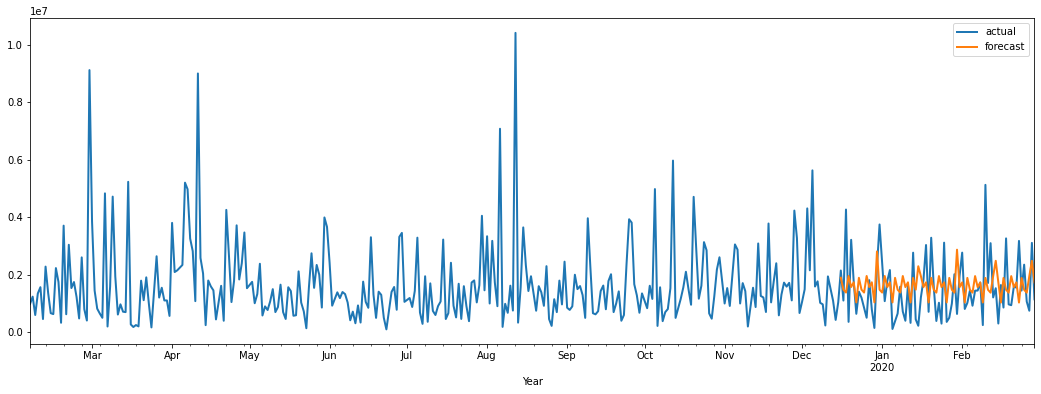

In [17]:
series.plot(label="actual", lw=2, figsize=(18,6))
prediction_prophet.plot(label="forecast", lw=2, figsize=(18,6))
plt.legend()
plt.xlabel("Year")

In [18]:
print('The SuMAPE for Prophet is: {:.2f}.'.format(sumape(val, prediction_prophet)))

The SuMAPE for Prophet is: 27.55.


### Ensembling several predictions
We manually combined a naive seasonal model with a naive drift model.
Here, we will try to find such combinations in an automated way, using RegressionModels.
A regression model is a model that predicts a target time series from a bunch of features time series.
If the features time series are themselves obtained from forecasting models, their future (predicted) values can be combined using the regression model to obtain a final forecast.

Here, we will first compute the historical predictions two naive seasonal models (with 7 and 14 days seasonality), and naive drift model.
To compute the historical predictions, we can simply reuse the backtest_forecasting() method:

In [19]:
models_naive = [models.NaiveSeasonal(7), models.NaiveSeasonal(14), models.NaiveDrift()]

model_predictions = [backtesting.backtest_forecasting(series, m, pd.Timestamp(date_division), fcast_horizon_n=14, verbose=False) for m in models_naive]

In [20]:
regr_model = models.StandardRegressionModel(train_n_points=14)

series_target = series.slice_intersect(model_predictions[0])

regr_date_division = '20200101'	
ensemble_pred = backtesting.backtest_regression(model_predictions, series_target, regr_model, pd.Timestamp(regr_date_division), fcast_horizon_n=3, verbose=False)

Text(0.5, 0, 'SuMAPE Error ensemble: 27.40%')

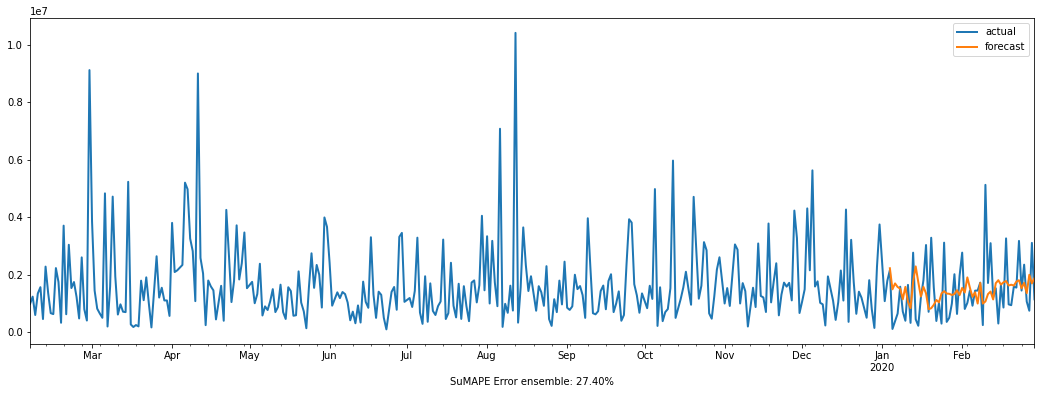

In [21]:
title = 'SuMAPE Error ensemble: {:.2f}%'.format(sumape(series, ensemble_pred))
series.plot(label="actual", lw=2, figsize=(18,6))
ensemble_pred.plot(label="forecast", lw=2, figsize=(18,6))
plt.legend()
plt.xlabel(title)

## Metrics
Darts have most used metrics built in: 
* MAE
* MSE
* RMSE
* RMSLE (Log error)
* MAPE
* MASE

And more.

Also you can create your own metric:


In [22]:
@metrics.metrics.multivariate_support
def sumape(
    actual_series: TimeSeries,
    pred_series: TimeSeries,
    intersect: bool = True,
    reduction: Callable[[np.ndarray], float] = np.mean ) -> float:

    y_true, y_hat = metrics.metrics._get_values_or_raise(
        actual_series, pred_series, intersect
    )
    # You can ask if a value is 0.
    # metrics.metrics.raise_if_not(
    #    (y_true != 0).all() ,
    #    "The actual series must be strictly positive to compute the SuMAPE.",
    # )
    return (np.abs(y_hat - y_true).sum() / (np.abs(y_true) + np.abs(y_hat)).sum()) * 100

For instance a new metric, you should add the decorator so you can use it with multivariate TimeSeries

## Preprocessing
Has 1 preprocessing built-in function, `ScalerWrapper` scales the values between `[0,1]` by default.

## Backtesting
Backtesting functions only work for univariant TimeSeries, except grid-search

* `backtest_forecasting`: Backtesting for models, retrain the model for the available history. 
* `backtest_regression`: Backtesting for regression models, as seen in the example above
* `backtest_gridsearch`: grid search for a given model and dictionary with hyperparameter. 
* `explore_models` : exploring the suitability of multiple models on a given train/validation/test split. 

### Backtesting forecasting

In [23]:
backtest_series = backtesting.backtest_forecasting(series, models.ExponentialSmoothing(), pd.Timestamp(date_division), fcast_horizon_n=3, verbose=False)

Text(0.5, 0, 'SuMAPE Error ensemble: 28.82%')

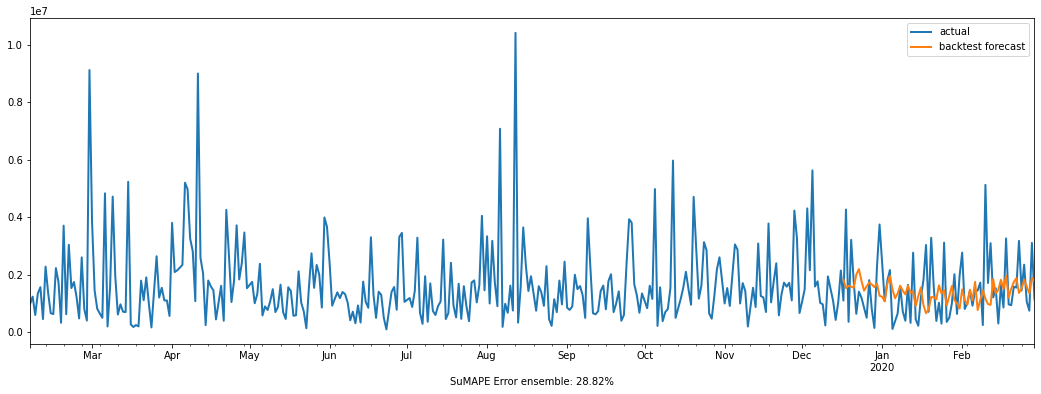

In [24]:
title = 'SuMAPE Error ensemble: {:.2f}%'.format(sumape(series, backtest_series))
series.plot(label="actual", lw=2, figsize=(18,6))
backtest_series.plot(label="backtest forecast", lw=2, figsize=(18,6))
plt.legend()
plt.xlabel(title)

### Explore models function

In [25]:
date_division_val = "20191014"
date_division_test = "20191228"
series = TimeSeries.from_dataframe(df_992133, "ds", "y" )
series = missing_values.auto_fillna(series, method="slinear")
train, val_test = series.split_after(pd.Timestamp(date_division_val))
val, test = val_test.split_after(pd.Timestamp(date_division_test))
len(train) , len(val), len(test) 

(252, 75, 63)

ib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/fabian/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
[2020-07-24 12:09:05,070] INFO | darts.backtesting.backtesting | Chosen parameters: {'trend': 'multiplicative', 'seasonal': 'multiplicative', 'seasonal_periods': 7}
INFO:darts.backtesting.backtesting:Chosen parameters: {'trend': 'multiplicative', 'seasonal': 'multiplicative', 'seasonal_periods': 7}
[2020-07-24 12:09:06,530] INFO | darts.backtesting.backtesting | Chosen parameters: {'K': 18}
INFO:darts.backtesting.backtesting:Chosen parameters: {'K': 18}
[2020-07-24 12:09:07,878] INFO | darts.backtesting.backtesting | Chosen parameters: {'nr_freqs_to_keep': 2, 'trend': None}
INFO:darts.backtesting.backtesting:Chosen parameters: {'nr_freqs_to_keep': 2, 'tr

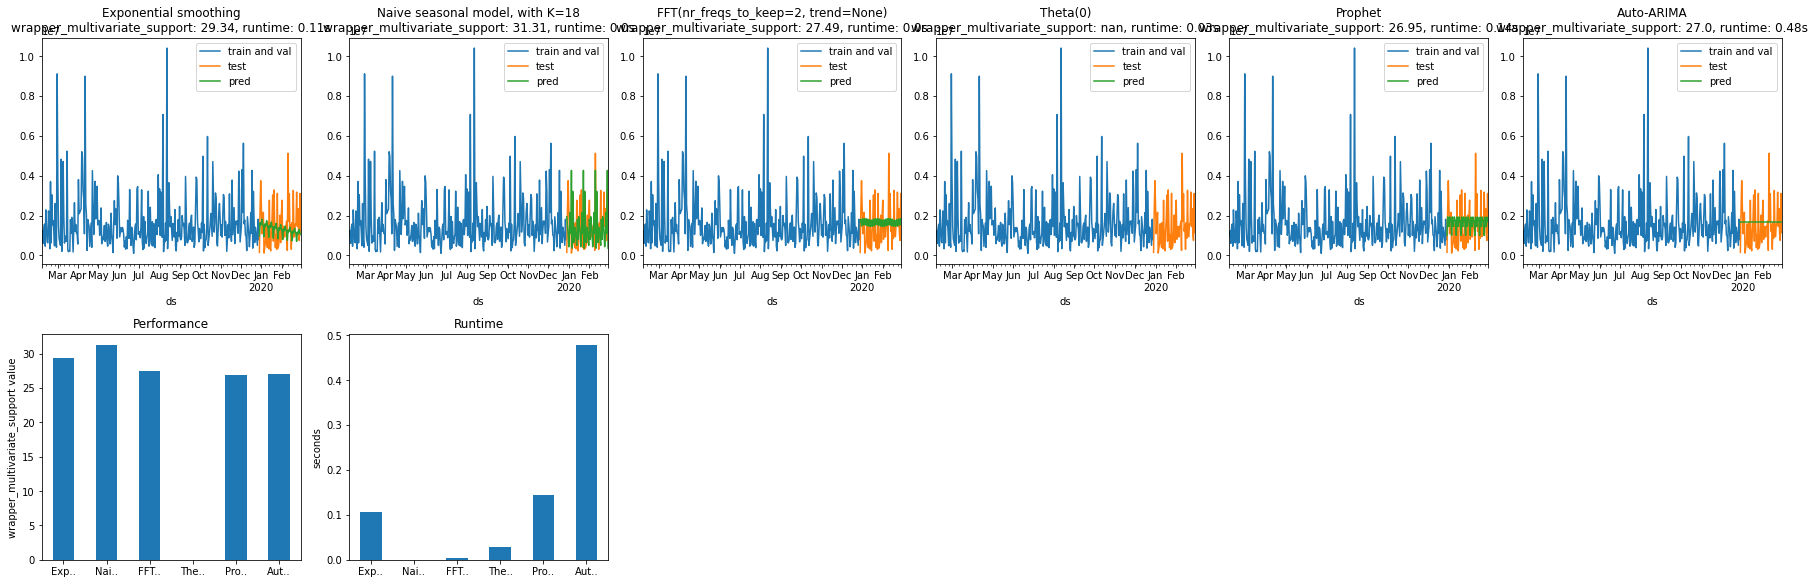

In [26]:
backtesting.backtesting.explore_models(train, val, test, metric=sumape, verbose=False, plot_width=9)